# Regression Exploration

In this notebook we will explore several types of regression models to see which type seems to fit the data best. We will dive deeper into a few of the best performing models to see if there is any way to improve them.

In [22]:
!conda install -c conda-forge python-chromedriver-binary

Solving environment: done

# All requested packages already installed.



In [57]:
import warnings
warnings.filterwarnings('ignore')

import importlib.util
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, RepeatedKFold, GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

import xgboost as xg

import numpy as np
import pandas as pd
import pickle
from collections import Counter, defaultdict

import altair as alt
from altair_saver import save
from scipy.stats import skew
import joblib
import json

alt.renderers.enable('png');

--------
## Data Cleaning

### Set Up

Time columns that need to be converted to integer hour for model:

In [2]:
parse_times = ["MKOPEN", "MKCLOSE", "MKEMHOPEN", "MKEMHCLOSE",
               "MKOPENYEST", "MKCLOSEYEST", "MKOPENTOM",
               "MKCLOSETOM","EPOPEN", "EPCLOSE", "EPEMHOPEN",
               "EPEMHCLOSE", "EPOPENYEST", "EPCLOSEYEST",
               "EPOPENTOM", "EPCLOSETOM", "HSOPEN", "HSCLOSE",
               "HSEMHOPEN", "HSEMHCLOSE", "HSOPENYEST", "HSCLOSEYEST",
               "HSOPENTOM", "HSCLOSETOM", "AKOPEN", "AKCLOSE",
               "AKEMHOPEN", "AKOPENYEST", "AKCLOSEYEST","AKEMHCLOSE",
               "AKOPENTOM", "AKCLOSETOM", "MKPRDDT1", "MKPRDDT2",
               "MKPRDNT1", "MKPRDNT2", "MKFIRET1", "MKFIRET2",
               "EPFIRET1", "EPFIRET2", "HSPRDDT1", "HSFIRET1",
               "HSFIRET2", "HSSHWNT1", "HSSHWNT2", "AKPRDDT1",
               "AKPRDDT2", "AKSHWNT1", "AKSHWNT2"]

### Load posted wait time datasets

In [3]:
def setup():
    with open("../data/processed/dtypes_parsed.json") as json_file:
        dtypes = json.load(json_file)

    return dtypes


def loadTrainTestPostedWaitTimes():
    """
            Loads train test data for posted wait times

            How to use:

            import importlib.util

            spec = importlib.util.spec_from_file_location("loadTrainTestPostedWaitTimes", "src/data/loadTrainTestData.py")
            loadTrainPosted = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(loadTrainPosted)

            X_train_posted, X_test_posted, y_train_posted, y_test_posted = loadTrainPosted.loadTrainTestPostedWaitTimes()

            Parameters
            ----------

            Returns
            -------
            rideDataDf_trainX - train data features for posted wait times
            rideDataDf_testX - test data features for posted wait times
            rideDataDf_trainY - train data targets for posted wait times
            rideDataDf_testY - test data targets for posted wait times

        """
    parse_dates = ['date', 'datetime']
    X_train_list = []
    y_train_list = []
    dtypes = setup()

    for year in range(2015, 2022):

        rideData = pd.read_csv(f'../data/processed/All_train_postedtimes{year}.csv', dtype=dtypes,
                               parse_dates=parse_dates, compression='gzip')
        rideDataX = rideData.drop(columns=["POSTED_WAIT"])
        rideDataY = rideData["POSTED_WAIT"]
        X_train_list.append(rideDataX)
        y_train_list.append(rideDataY)

    rideDataDf_trainX = pd.concat(X_train_list, ignore_index=True)
    rideDataDf_trainY = pd.concat(y_train_list, ignore_index=True)


    X_test_list = []
    y_test_list = []

    for year in range(2015, 2022):
        rideData = pd.read_csv(f'../data/processed/All_test_postedtimes{year}.csv', dtype=dtypes,
                               parse_dates=parse_dates, compression='gzip')
        rideDataX = rideData.drop(columns=["POSTED_WAIT"])
        rideDataY = rideData["POSTED_WAIT"]

        X_test_list.append(rideDataX)
        y_test_list.append(rideDataY)

    rideDataDf_testX = pd.concat(X_test_list, ignore_index=True)
    rideDataDf_testY = pd.concat(y_test_list, ignore_index=True)

    return rideDataDf_trainX, rideDataDf_testX, rideDataDf_trainY, rideDataDf_testY

In [4]:
X_train, X_test, y_train, y_test = loadTrainTestPostedWaitTimes()

### Convert key data points from date to integer

In [5]:
X_train["MONTHOFYEAR"] = X_train["date"].dt.month.astype("Int8")
X_train["YEAR"] = X_train["date"].dt.year.astype("Int16")
X_train["DAYOFYEAR"] = X_train["date"].dt.dayofyear.astype("Int16")
X_train["HOUROFDAY"] = X_train["datetime"].dt.hour.astype("Int8")

X_test["MONTHOFYEAR"] = X_test["date"].dt.month.astype("Int8")
X_test["YEAR"] = X_test["date"].dt.year.astype("Int16")
X_test["DAYOFYEAR"] = X_test["date"].dt.dayofyear.astype("Int16")
X_test["HOUROFDAY"] = X_test["datetime"].dt.hour.astype("Int8")

### Sort by datetime before imputation (keeping y-values associated)

In [6]:
train = pd.concat([X_train, y_train], axis=1).sort_values(['datetime'])
test = pd.concat([X_test, y_test], axis=1).sort_values(['datetime'])

In [7]:
X_train_impute = train.drop(columns=["POSTED_WAIT"])
y_train = train["POSTED_WAIT"]

X_test_impute = test.drop(columns=["POSTED_WAIT"])
y_test = test["POSTED_WAIT"]

### Many open/close times, parade times, etc. are in HH:MM format. 

Convert to integer hour & fill nulls with 99.

This means that particulate event does not exist for that day. (e.g. Magic Kingdom doesn't have a second parade)

In [8]:
for col in parse_times:
    X_train_impute[col] =  X_train_impute[col].fillna("99")
    X_train_impute[f"{col}_HOUR"] = X_train_impute[col].apply(lambda x: x[:2] if x[0]!=0 else x[:1]).astype(int).astype("Int8")
    X_train_impute.drop(columns = col, inplace=True)

In [9]:
for col in parse_times:
    X_test_impute[col] =  X_test_impute[col].fillna("99")
    X_test_impute[f"{col}_HOUR"] = X_test_impute[col].apply(lambda x: x[:2] if x[0]!=0 else x[:1]).astype(int).astype("Int8")
    X_test_impute.drop(columns = col, inplace=True)

### Data Imputation

First impute by backfilling values. For any remaining nulls, impute the median.

In [10]:
for col in X_train_impute.columns:
    nulls = X_train_impute[col].isnull().sum()
    
    if nulls>0:
        X_train_impute[col].fillna(method ='bfill', inplace=True)
    
        if X_train_impute[col].isnull().sum()>0:
            X_train_impute[col].fillna(X_train_impute[col].median(), inplace=True)

In [11]:
for col in X_test_impute.columns:
    nulls = X_test_impute[col].isnull().sum()
    if nulls>0:
        X_test_impute[col]= X_test_impute[col].fillna(method ='bfill')
        
        if X_test_impute[col].isnull().sum()>0:
            X_test_impute[col].fillna(X_test_impute[col].median(), inplace=True)

### Drop Datetime columns - no longer needed

In [12]:
X_train_encoded = X_train_impute.drop(columns=['date', 'datetime', 'Unnamed: 0'])
X_test_encoded = X_test_impute.drop(columns=['date', 'datetime', 'Unnamed: 0'])

In [13]:
del X_train_impute, X_test_impute

### Data Scaling & Transformation

Log Transform skewed numeric columns & then apply StandardScaler to scale numeric columns.

In [15]:
scaler = RobustScaler()


X_dtype_train = X_train_encoded.select_dtypes(include=[np.number]).reset_index(drop=True)
num_cols = list(X_dtype_train.columns)

X_dtype_test = X_test_encoded.select_dtypes(include=[np.number]).reset_index(drop=True)

In [16]:
skewed_cols = []
for col in X_dtype_train.columns:
    skewness = abs(skew(list(X_dtype_train[col])))
    if skewness > 1:
        X_dtype_train[f"log_{col}"] = np.log(X_dtype_train[col].astype(float).apply(lambda x: x+5))
        X_dtype_test[f"log_{col}"] = np.log(X_dtype_test[col].astype(float).apply(lambda x: x+5))                                         
        skewed_cols.append(col)

X_dtype_train.drop(columns=skewed_cols, inplace=True)
X_dtype_test.drop(columns=skewed_cols, inplace=True)

In [17]:
X_train_norm = scaler.fit_transform(X_dtype_train)
X_test_norm = scaler.transform(X_dtype_test)

X_train_encoded[num_cols] = X_train_norm
X_test_encoded[num_cols] = X_test_norm

In [18]:
del X_train_norm, X_test_norm, X_dtype_train, X_dtype_test

------

# Modeling

## Dummy Regression - Baseline

Setting baseline metrics to see improvement among other models. These models are not expected to do well.

In [18]:
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train_encoded, y_train)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test_encoded)

In [19]:
print("DUMMY REGRESSOR - MEAN")
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_predict_dummy_mean))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_predict_dummy_mean))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_predict_dummy_mean)))
print("R-SQUARED: ", metrics.r2_score(y_test, y_predict_dummy_mean))

DUMMY REGRESSOR - MEAN
Mean Absolute Error (MAE): 162.41068811170675
Mean Squared Error (MSE): 84453.25944579137
Root Mean Squared Error (RMSE): 290.6084297569349
R-SQUARED:  -3.6194275621070915e-07


In [20]:
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train_encoded, y_train)
y_predict_dummy_median = lm_dummy_median.predict(X_test_encoded)

In [21]:
print("DUMMY REGRESSOR - MEDIAN")

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_predict_dummy_median))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_predict_dummy_median))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_predict_dummy_median)))
print("R-SQUARED: ", metrics.r2_score(y_test, y_predict_dummy_median))

DUMMY REGRESSOR - MEDIAN
Mean Absolute Error (MAE): 106.43553661159103
Mean Squared Error (MSE): 90904.36571096092
Root Mean Squared Error (RMSE): 301.5035086213109
R-SQUARED:  -0.07638709517762399


## Ridge Regression w/ Grid Search on Alpha

Testing ridge regression with differing levels of alpha. This model does not do very well compared to the dummy regressors. We will not move forward with ridge regression.

In [22]:
linRidge = RidgeCV(alphas=[1e-1, 1, 10], scoring='neg_mean_absolute_error').fit(X_train_encoded, y_train)
predLinRidge = linRidge.predict(X_test_encoded)

In [24]:
print("RIDGE REGRESSION GRID SEARCH: ")
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predLinRidge))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predLinRidge))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predLinRidge)))
print("R-SQUARED: ", metrics.r2_score(y_test, predLinRidge))

RIDGE REGRESSION GRID SEARCH: 
Mean Absolute Error (MAE): 141.39446762707306
Mean Squared Error (MSE): 69836.10725051745
Root Mean Squared Error (RMSE): 264.2652214168892
R-SQUARED:  0.17307948816330976


## XGBoost Regressor

```n_estimators = 100```

XGBoost regressor does significantly better than the dummy regressors, however it's not doing as well as we'd hope. We will put this one aside for now and continue exploring.

In [25]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 100, seed = 123)
# Fitting the model
xgb_r.fit(X_train_encoded, y_train)
# Predict the model
pred = xgb_r.predict(X_test_encoded)

In [26]:
print("XGBoost n_estimators = 100")
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print("R-SQUARED: ", metrics.r2_score(y_test, pred))

XGBoost n_estimators = 100
Mean Absolute Error (MAE): 81.98376024978742
Mean Squared Error (MSE): 38018.90601036953
Root Mean Squared Error (RMSE): 194.9843737594619
R-SQUARED:  0.5498229432406851


## Bayesian Ridge Regressor

Bayesian Ridge regressor has similar results to traditional Ridge which does not perform well. We will not move forward with this model.

In [27]:
BayReg = BayesianRidge()
BayReg.fit(X_train_encoded, y_train)
pred = BayReg.predict(X_test_encoded)

In [28]:
print("Bayesian Ridge Regression: ")
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print("R-SQUARED: ", metrics.r2_score(y_test, pred))

Bayesian Ridge Regression: 
Mean Absolute Error (MAE): 141.4040042726355
Mean Squared Error (MSE): 69840.6091746251
Root Mean Squared Error (RMSE): 264.2737390938137
R-SQUARED:  0.1730261814494347


-----------------------

# Tree-Based Model Deep Dive

Our analysis showed us that tree based models do fairly well on this data. We will further explore these models to determine if we can maximize the performance and minimize the complexity of these models.

## Random Forest Regression

We resorted to doing hyperparameter tuning manually because GCP threw a TerminatedWorkerError during GridSearchCV and RandomizedSearchCV efforts and running the same thing locally threw memory errors.

In [19]:
important_features = {}
rfResults = {}
feature_dict = defaultdict(list)
rf_feature_importance = defaultdict(dict)
for n_est in (10, 50, 100):
    for max_depth in [10, 50, 100]:
        print(f"STARTING {n_est}, {max_depth}")
        rfc = RandomForestRegressor(n_estimators=n_est, max_depth=max_depth, random_state=0, n_jobs=-1)
        rfc.fit(X_train_encoded, y_train)
        
        pred = rfc.predict(X_test_encoded)
        
        mae = metrics.mean_absolute_error(y_test, pred)
        mse = metrics.mean_squared_error(y_test, pred)
        rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
        r2 = metrics.r2_score(y_test, pred)
        
        rfResults[f"{n_est}_{max_depth}"] = {"mae": mae, "mse": mse, "rmse":rmse, "r2":r2}
        
        importances = rfc.feature_importances_
        important_feat = np.argsort(importances)[-50:]
        
        selected_feat_names= list(X_train.columns[important_feat])
        
        for idx, x in enumerate(important_feat):
            feature_dict[selected_feat_names[idx]].append(importances[x])
            
            try:
                rf_feature_importance[selected_feat_names[idx]]["count"] += 1
                rf_feature_importance[selected_feat_names[idx]]["importances"].append(importances[x])
            except KeyError:
                rf_feature_importance[selected_feat_names[idx]]["count"] = 1
                rf_feature_importance[selected_feat_names[idx]]["importances"] = [importances[x]]
            
    
print(rfResults)

STARTING 10, 10
STARTING 10, 50
STARTING 10, 100
STARTING 50, 10
STARTING 50, 50
STARTING 50, 100
STARTING 100, 10
STARTING 100, 50
STARTING 100, 100
{'10_10': {'mae': 82.36201801338278, 'mse': 42287.0163817075, 'rmse': 205.63807133336837, 'r2': 0.499284788240413}, '10_50': {'mae': 40.457268737194994, 'mse': 22579.505254077438, 'rmse': 150.2647838120344, 'r2': 0.7326389345451009}, '10_100': {'mae': 40.42807329716989, 'mse': 22584.17400055107, 'rmse': 150.28031807442738, 'r2': 0.732583652508693}, '50_10': {'mae': 82.13680600195903, 'mse': 42014.967179508305, 'rmse': 204.97552824546716, 'r2': 0.5025060884300173}, '50_50': {'mae': 40.29108059016234, 'mse': 22208.973535539466, 'rmse': 149.02675442865777, 'r2': 0.7370263537528471}, '50_100': {'mae': 40.281353116397874, 'mse': 22215.283708694125, 'rmse': 149.04792420122504, 'r2': 0.7369516357907461}, '100_10': {'mae': 81.96562853215062, 'mse': 41904.37406963158, 'rmse': 204.7055789900011, 'r2': 0.5038156074542782}, '100_50': {'mae': 40.24235

## RandomForest Grid Search Results

It appears that the sweet spot for metrics optimization vs. model complexity is **10 estimators and max depth of 50 for each tree**. Additional trees beyond 10 does not add value to the model and there is a sigificant reduction in error and increase in r-squared after increasing max-depth to 50. However, more than 50 max_depth for each tree does not seem to increase value.

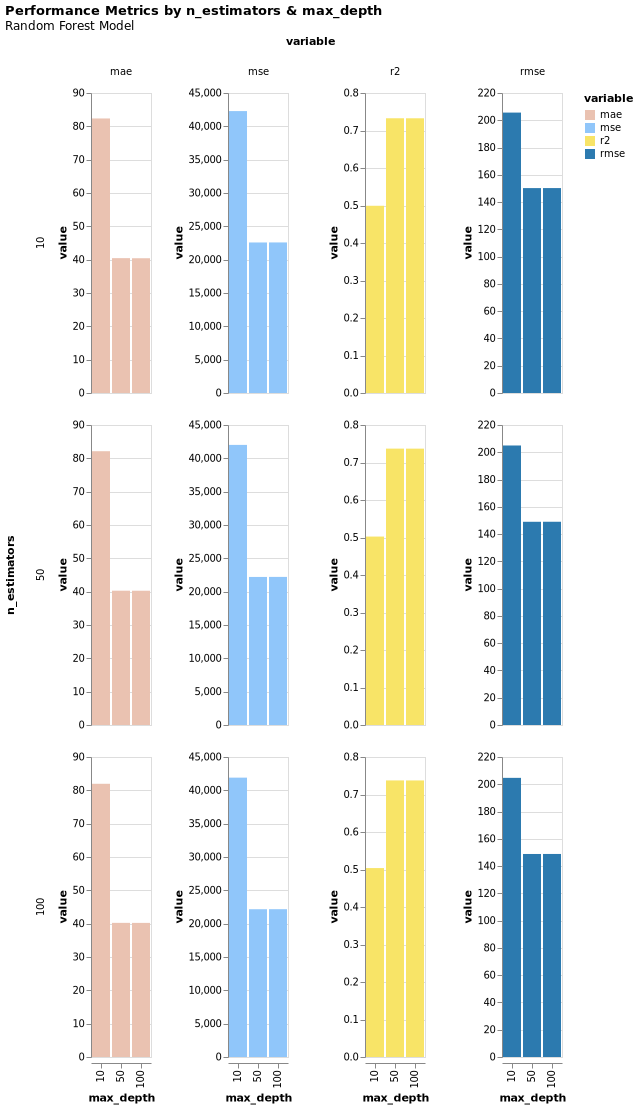

In [58]:
rfGridSearchResults = pd.DataFrame.from_dict(rfResults).T.reset_index()

rfGridSearchResults[['n_estimators', 'max_depth']] = rfGridSearchResults['index'].str.split("_", expand=True).astype(int)
rfGridSearchResults = rfGridSearchResults.melt(id_vars=["index", "n_estimators", "max_depth"])

rfMetricsChart = alt.Chart(rfGridSearchResults).mark_bar().encode(
    x='max_depth:N',
    y='value:Q',
    color=alt.Color('variable:N', scale = alt.Scale(range=["#EAC2B1", "#90C6FA", "#F8E467", "#2C7AAF"])),
    row='n_estimators:N',
    column='variable:N',
).resolve_scale(
  y='independent'
).properties(
    title={
    "text": ["Performance Metrics by n_estimators & max_depth"],
      "subtitle": ["Random Forest Model"]
    }
)

save(rfMetricsChart, "../reports/figures/GridSearchRandomForest.png")

rfMetricsChart

### Top Features for Random Forest

Top 25 Features sorted on how many of the 9 Random Forest models considered it important and mean importance among those models:

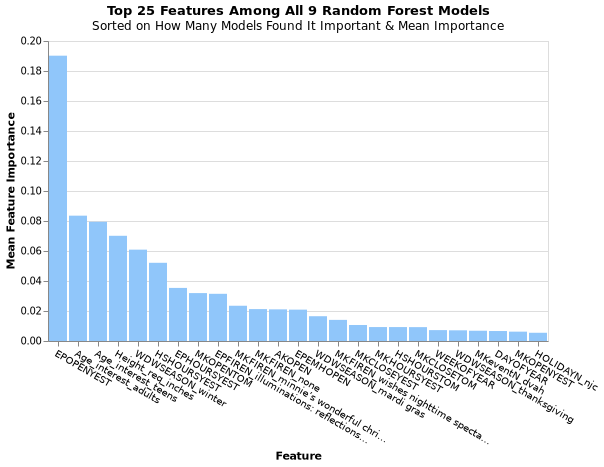

In [59]:
for x in rf_feature_importance:
    rf_feature_importance[x]["mean_importance"] = np.mean(rf_feature_importance[x]["importances"])
    
rfGridSearchFeatImp = pd.DataFrame.from_dict(rf_feature_importance).T.reset_index().sort_values(by=['mean_importance', 'count'], ascending=False)

top25 = rfGridSearchFeatImp.head(25)


rfFeatImpChart = alt.Chart(top25).mark_bar(color = "#90C6FA").encode(
    x=alt.X('index:N', sort='-y', axis=alt.Axis(labelAngle=30), title = "Feature"),
    y=alt.Y('mean_importance:Q', title = "Mean Feature Importance")).properties(
    title={
    "text": ["Top 25 Features Among All 9 Random Forest Models"],
      "subtitle": ["Sorted on How Many Models Found It Important & Mean Importance"]
    }
)
save(rfFeatImpChart, "../reports/figures/GridSearchRFFeatureImportance.png")
    
rfFeatImpChart

## Extra Trees Regressor

Extra Trees regressor is supposed to help with overfitting in RandomForest models. We tried this model to see if we could improve the performance on the test set, however, we got very similar results to Random Forest so have decided not to go with this model.

In [54]:
important_features = {}
etResults = {}
feature_dict = defaultdict(list)
et_feature_importance = defaultdict(dict)
for n_est in (10, 50, 100):
    for max_depth in [10, 50, 100]:
        print(f"STARTING {n_est}, {max_depth}")
        etr = ExtraTreesRegressor(n_estimators=n_est, max_depth=max_depth, random_state=0, n_jobs=-1)
        etr.fit(X_train_encoded, y_train)
        
        pred = etr.predict(X_test_encoded)
        
        mae = metrics.mean_absolute_error(y_test, pred)
        mse = metrics.mean_squared_error(y_test, pred)
        rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
        r2 = metrics.r2_score(y_test, pred)
        
        etResults[f"{n_est}_{max_depth}"] = {"mae": mae, "mse": mse, "rmse":rmse, "r2":r2}
        
        importances = etr.feature_importances_
        important_feat = np.argsort(importances)[-50:]
        
        selected_feat_names= list(X_train.columns[important_feat])
        
        for idx, x in enumerate(important_feat):
            feature_dict[selected_feat_names[idx]].append(importances[x])
            
            try:
                et_feature_importance[selected_feat_names[idx]]["count"] += 1
                et_feature_importance[selected_feat_names[idx]]["importances"].append(importances[x])
            except KeyError:
                et_feature_importance[selected_feat_names[idx]]["count"] = 1
                et_feature_importance[selected_feat_names[idx]]["importances"] = [importances[x]]
            
    
print(etResults)

STARTING 10, 10
STARTING 10, 50
STARTING 10, 100
STARTING 50, 10
STARTING 50, 50
STARTING 50, 100
STARTING 100, 10
STARTING 100, 50
STARTING 100, 100
{'10_10': {'mae': 92.95140587529919, 'mse': 44700.12928111366, 'rmse': 211.42405085778122, 'r2': 0.47071142365211294}, '10_50': {'mae': 40.13122904753853, 'mse': 22941.65829571273, 'rmse': 151.46503984653597, 'r2': 0.7283507261906748}, '10_100': {'mae': 40.139040173664895, 'mse': 22952.065080439406, 'rmse': 151.49938970319124, 'r2': 0.7282275007691619}, '50_10': {'mae': 92.58374706149999, 'mse': 44305.13164006113, 'rmse': 210.48784202433436, 'r2': 0.4753885407534678}, '50_50': {'mae': 40.12996160162398, 'mse': 22925.948211568233, 'rmse': 151.41317053535414, 'r2': 0.7285367473097379}, '50_100': {'mae': 40.130332094998316, 'mse': 22929.292872811064, 'rmse': 151.42421494863714, 'r2': 0.728497143599054}, '100_10': {'mae': 92.20082295970086, 'mse': 44179.23326329713, 'rmse': 210.18856596707903, 'r2': 0.4768792875068577}, '100_50': {'mae': 40.1

## Extra Trees Grid Search Results

It appears that the sweet spot for metrics optimization vs. model complexity is 10 estimators and max of 50 trees.

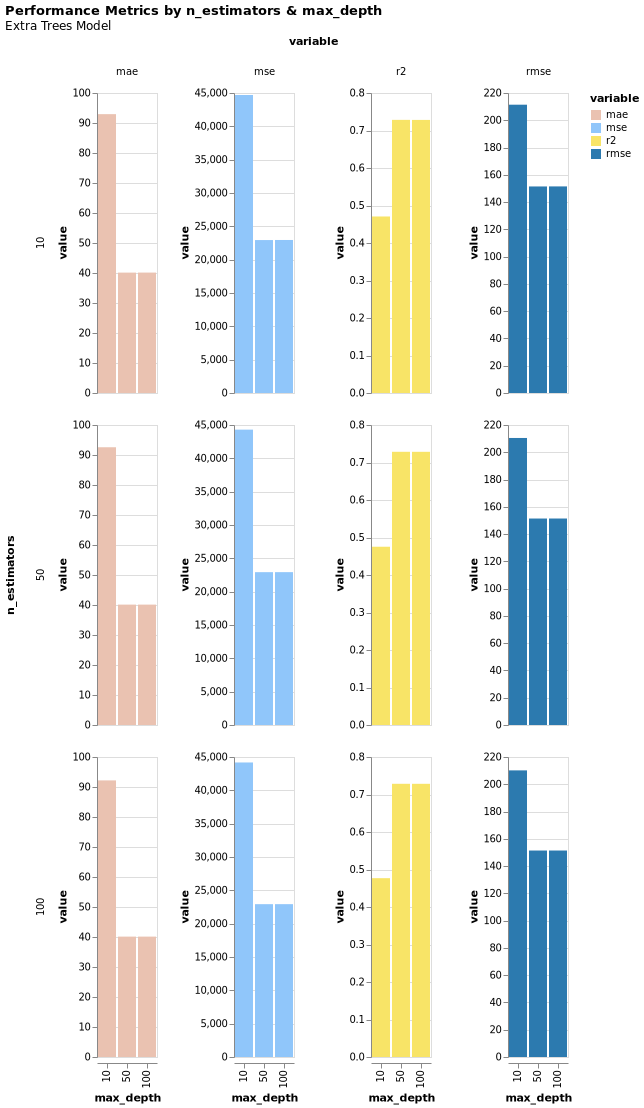

In [60]:
etGridSearchResults = pd.DataFrame.from_dict(etResults).T.reset_index()

etGridSearchResults[['n_estimators', 'max_depth']] = etGridSearchResults['index'].str.split("_", expand=True).astype(int)
etGridSearchResults = etGridSearchResults.melt(id_vars=["index", "n_estimators", "max_depth"])

etMetricsChart = alt.Chart(etGridSearchResults).mark_bar().encode(
    x='max_depth:N',
    y='value:Q',
    color=alt.Color('variable:N', scale = alt.Scale(range=["#EAC2B1", "#90C6FA", "#F8E467", "#2C7AAF"])),
    row='n_estimators:N',
    column='variable:N',
).resolve_scale(
  y='independent'
).properties(
    title={
    "text": ["Performance Metrics by n_estimators & max_depth"],
      "subtitle": ["Extra Trees Model"]
    }
)

save(etMetricsChart, '../reports/figures/GridSearchExtraTrees.png')
etMetricsChart

### Top Features for Extra Trees

Top 25 Features sorted on how many of the 9 Extra trees models considered it important and mean importance among those models:

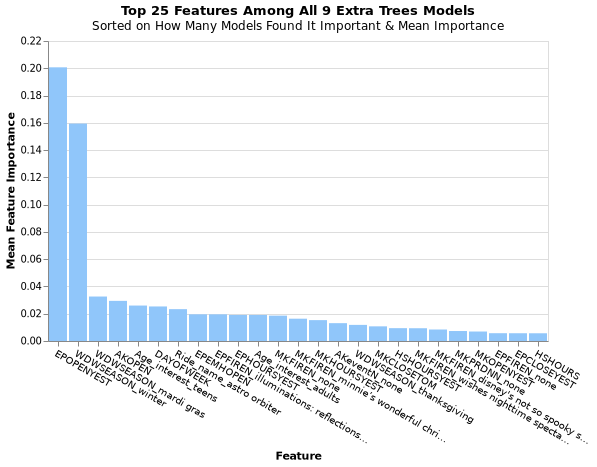

In [61]:
for x in et_feature_importance:
    et_feature_importance[x]["mean_importance"] = np.mean(et_feature_importance[x]["importances"])

etGridSearchFeatImp = pd.DataFrame.from_dict(et_feature_importance).T.reset_index().sort_values(by=['mean_importance', 'count'], ascending=False)

top25_et = etGridSearchFeatImp.head(25)


etGridSearchFeatImp = alt.Chart(top25_et).mark_bar(color = "#90C6FA").encode(
    x=alt.X('index:N', sort='-y', axis=alt.Axis(labelAngle=30), title = "Feature"),
    y=alt.Y('mean_importance:Q', title = "Mean Feature Importance")).properties(
    title={
    "text": ["Top 25 Features Among All 9 Extra Trees Models"],
      "subtitle": ["Sorted on How Many Models Found It Important & Mean Importance"]
    }
)
save(etGridSearchFeatImp, "../reports/figures/GridSearchETFeatureImportance.png")
    
etGridSearchFeatImp

### Decision Tree Regressor

In [74]:
important_features = {}
dtResults = {}
feature_dict = defaultdict(list)
dt_feature_importance = defaultdict(dict)
for max_depth in [10, 50, 100, None]:
    print(f"STARTING Max Depth {max_depth}")
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
    dt.fit(X_train_encoded, y_train)

    pred = dt.predict(X_test_encoded)

    mae = metrics.mean_absolute_error(y_test, pred)
    mse = metrics.mean_squared_error(y_test, pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
    r2 = metrics.r2_score(y_test, pred)

    dtResults[f"{max_depth}"] = {"mae": mae, "mse": mse, "rmse":rmse, "r2":r2}

    importances = dt.feature_importances_
    important_feat = np.argsort(importances)[-50:]

    selected_feat_names= list(X_train.columns[important_feat])

    for idx, x in enumerate(important_feat):
        feature_dict[selected_feat_names[idx]].append(importances[x])

        try:
            dt_feature_importance[selected_feat_names[idx]]["count"] += 1
            dt_feature_importance[selected_feat_names[idx]]["importances"].append(importances[x])
        except KeyError:
            dt_feature_importance[selected_feat_names[idx]]["count"] = 1
            dt_feature_importance[selected_feat_names[idx]]["importances"] = [importances[x]]


print(dtResults)

STARTING Max Depth 10
STARTING Max Depth 50
STARTING Max Depth 100
STARTING Max Depth None
{'10': {'mae': 82.5697016324016, 'mse': 42796.51522047903, 'rmse': 206.87318632553382, 'r2': 0.4932518769410217}, '50': {'mae': 40.19006682345901, 'mse': 23210.514305829132, 'rmse': 152.3499731074119, 'r2': 0.7251672361845908}, '100': {'mae': 40.165132561672415, 'mse': 23198.939656900307, 'rmse': 152.31198133075515, 'r2': 0.725304290138389}, 'None': {'mae': 40.165132561672415, 'mse': 23198.939656900307, 'rmse': 152.31198133075515, 'r2': 0.725304290138389}}


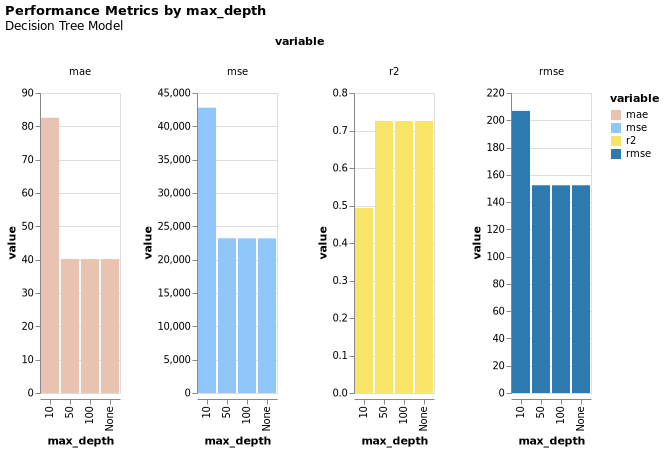

In [76]:
dtGridSearchResults = pd.DataFrame.from_dict(dtResults).T.reset_index()

dtGridSearchResults['max_depth'] = dtGridSearchResults['index']

dtGridSearchResults.drop(columns=['index'], inplace=True)
dtGridSearchResults = dtGridSearchResults.melt(id_vars=["max_depth"])

dtMetricsChart = alt.Chart(dtGridSearchResults).mark_bar().encode(
    x=alt.X('max_depth:N', sort=['10', '50', '100', 'None']),
    y='value:Q',
    color=alt.Color('variable:N', scale = alt.Scale(range=["#EAC2B1", "#90C6FA", "#F8E467", "#2C7AAF"])),
    column='variable:N',
).resolve_scale(
  y='independent'
).properties(
    title={
    "text": ["Performance Metrics by max_depth"],
      "subtitle": ["Decision Tree Model"]
    }
)

save(dtMetricsChart, '../reports/figures/GridSearchDecisionTree.png')
dtMetricsChart

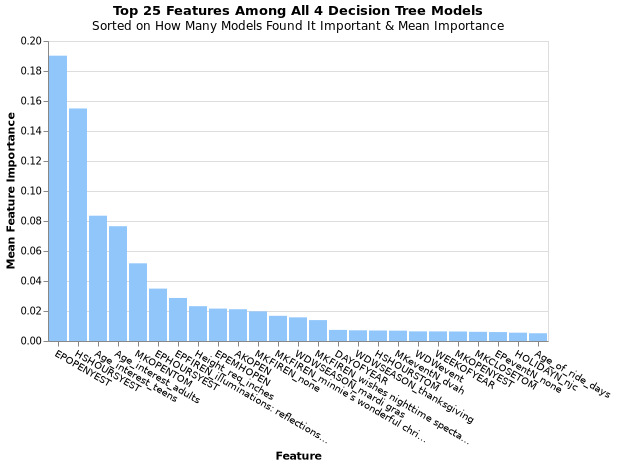

In [78]:
for x in dt_feature_importance:
    dt_feature_importance[x]["mean_importance"] = np.mean(dt_feature_importance[x]["importances"])

dtGridSearchFeatImp = pd.DataFrame.from_dict(dt_feature_importance).T.reset_index().sort_values(by=['mean_importance', 'count'], ascending=False)

top25_dt = dtGridSearchFeatImp.head(25)


dtGridSearchFeatImp = alt.Chart(top25_dt).mark_bar(color = "#90C6FA").encode(
    x=alt.X('index:N', sort='-y', axis=alt.Axis(labelAngle=30), title = "Feature"),
    y=alt.Y('mean_importance:Q', title = "Mean Feature Importance")).properties(
    title={
    "text": ["Top 25 Features Among All 4 Decision Tree Models"],
      "subtitle": ["Sorted on How Many Models Found It Important & Mean Importance"]
    }
)
save(dtGridSearchFeatImp, "../reports/figures/GridSearchDTFeatureImportance.png")
    
dtGridSearchFeatImp

----